# Modifications

Link to Interactive Notebook: 
https://colab.research.google.com/drive/1sbJTsgCsAQwCkGdLXK7EdgkaTpiTGBM1#scrollTo=T71qxHyh9p23

1. Reduced Input Dimension
2. Different handling of xco2
3. Custom rmse function

In [1]:
import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.model_selection import train_test_split
tf.random.set_seed(42)


sys.path.insert(0, '../src')

from utils import df_to_xarray,read_xarray,plot_image

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2021-10-20 14:17:48.928794: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# Reading Data
dir_name="../data/data1"
val_dir_name="../data/data2"

chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2=read_xarray(dir_name)



/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


## Data Preprocessing

In [1]:
def convert_nan(arr):
    """
    convert_nan(arr)
    - converts nan values to the lowest value (continents)
    """
    nans=np.isnan(arr)
    min_val=arr[~nans].min()
    arr[nans]=min_val-1
    return arr

def add_dimension(arr):
    """
    add_dimension(arr)
    - add one dimension to axis=3
    """
    images=np.expand_dims(arr, axis=3)
    return images

def scale_image(arr):
    """
    scale_image(arr)
    - scales numerical values from scale 0-255 for like an image
    - have tried, regular normal/ min-max scaler -> does not work well
    """
    ## Normal
    #arr=(arr-np.mean(arr))/np.std(arr)
    
    ## Min-Max
    # min_val=arr.min()
    # max_val=arr.max()
    # arr=arr/(min_val-max_val)

    ## Image Scale
    min_pixel = arr.min() 
    max_pixel = arr.max()
    new_min = 0
    new_max = 255
    arr = (arr-min_pixel)*(255)/(max_pixel-min_pixel)+new_min 
    return arr
  

def preprocess_image_reduced(data,xco2=False):
  """
  preprocess_image_reduced(data,xco2=False)
  wrapper function for image preprocessing process
  dimension reduced the output should be  (180,360,5)
  """
  if xco2:
    return data
  return scale_image(convert_nan(data))

In [4]:
## XCO2 Handling
# - xco2 values are a constant value across the globe, 
# - creating an image layer with constant value for the model
# - xco2 layer improves prediction

xco2_images=[]
min_xco2=np.min(xco2.XCO2.data)
max_xco2=np.max(xco2.XCO2.data)
new_min=0
new_max=255
print(min_xco2, max_xco2)
print()


for i in xco2.XCO2.data:
    num = (i-min_xco2)*(new_max-new_min)/(max_xco2-min_xco2)+new_min
    tmp = (np.repeat(num,180*360)).reshape(180,-1)
    xco2_images.append(tmp)

xco2_images=np.array(xco2_images)

print("xco2 shape: ")
print(xco2_images.shape, chl.Chl.data.shape)

chl_images=preprocess_image_reduced(chl.Chl.data)
mld_images=preprocess_image_reduced(mld.MLD.data)
sss_images=preprocess_image_reduced(sss.SSS.data)
sst_images=preprocess_image_reduced(sst.SST.data)
xco2_images=preprocess_image_reduced(xco2_images,xco2=True)

# need to preprocess pco2_image otherwise, the prediction does not work well
pco2_images=preprocess_image_reduced(pco2.pCO2.data)

# stacks image layer
X = np.stack((chl_images, mld_images, sss_images, sst_images,xco2_images), axis = 1)

340.84854 407.2084

xco2 shape: 
(421, 180, 360) (421, 180, 360)


In [5]:
# transform shapes to 421,180,360,5 | kernel = 5
X=X.reshape((421,180,360,5))
X.shape

(421, 180, 360, 5)

In [6]:
INPUT_SHAPE=X[0].shape
OUTPUT_SHAPE=pco2_images[0].shape

INPUT_SHAPE

(180, 360, 5)

## Modeling

### Image Segmentation
CNN - Unet

Reference: 
https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47


In [ ]:
import tensorflow.keras.backend as kb
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    y_pred = y_pred[y_true != 0]
    y_true = y_true[y_true != 0]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    
    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true), axis=-1))

### Base Model

In [8]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=5,activation='elu', padding="SAME")


base_model = keras.models.Sequential([
    DefaultConv2D(filters=64, input_shape=INPUT_SHAPE),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Dropout(0.3),

    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),

    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=64),    
    DefaultConv2D(filters=2),
    DefaultConv2D(filters=1,kernel_size=1),
    keras.layers.Reshape(OUTPUT_SHAPE)
   
])


## BEST SO FAR ##

base_model.summary()

2021-10-20 14:18:38.642106: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-20 14:18:38.706420: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-20 14:18:38.848695: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:d8:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 72 deviceMemorySize: 44.49GiB deviceMemoryBandwidth: 581.23GiB/s
2021-10-20 14:18:38.848751: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-20 14:18:39.872779: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-20 14:18:39.872901: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 360, 64)      8064      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 360, 64)      102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 120, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 120, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 120, 128)      204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 120, 128)      409728    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 180, 360, 128)     0

In [35]:
base_model.compile(loss=custom_rmse, optimizer="nadam", metrics=["mean_squared_error"])

In [40]:
model_path="../models/base_model/base_model_new.h5"
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

#batch size 32, 64 not as good
# batch size 16 the best
history = base_model.fit(X,pco2_images, epochs=100, validation_data=(X,pco2_images),workers=-1,batch_size=16,callbacks=callbacks)



Epoch 1/100
27/27 [==============================] - 10s 252ms/step - loss: 17.4042 - mean_squared_error: 406.1633 - val_loss: 16.2281 - val_mean_squared_error: 354.3571
Epoch 2/100
27/27 [==============================] - 6s 235ms/step - loss: 15.6310 - mean_squared_error: 333.6253 - val_loss: 15.0217 - val_mean_squared_error: 317.3038
Epoch 3/100
27/27 [==============================] - 6s 234ms/step - loss: 14.9563 - mean_squared_error: 311.8530 - val_loss: 14.8145 - val_mean_squared_error: 303.2607
Epoch 4/100
27/27 [==============================] - 6s 235ms/step - loss: 14.3286 - mean_squared_error: 291.3686 - val_loss: 14.7039 - val_mean_squared_error: 308.2136
Epoch 5/100
27/27 [==============================] - 6s 235ms/step - loss: 14.0670 - mean_squared_error: 284.4785 - val_loss: 13.3456 - val_mean_squared_error: 267.5653
Epoch 6/100
27/27 [==============================] - 6s 235ms/step - loss: 13.7451 - mean_squared_error: 275.0276 - val_loss: 12.9218 - val_mean_squared_e

### Base Model Output

In [41]:

best_model = tf.keras.models.load_model('../models/base_model/base_model_new.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_image=best_model.predict(X[419:421],verbose=1)

1/1 [==============================] - 0s 76ms/step


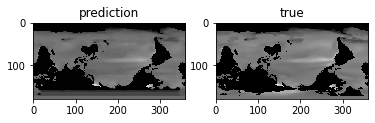

<Figure size 432x288 with 0 Axes>

In [42]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2)


axis[0].imshow(np.squeeze(predicted_image[1]), cmap="gray", interpolation="nearest")
axis[0].set_title("prediction")
axis[1].imshow(np.squeeze(pco2_images[419:421][1]), cmap="gray", interpolation="nearest")
axis[1].set_title("true")

plt.show()
plt.savefig('base_model_prediction.png')

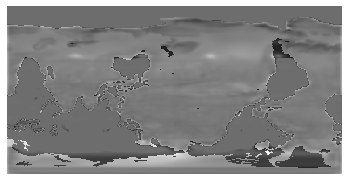

In [39]:
difference=np.squeeze(pco2_images[419:421][1])-np.squeeze(predicted_image[0])
plot_image(difference)

## Model 1

- more complex model with a greater parameters
- need a different learning rate

In [9]:

#kernel_size matters, 2 does not work

model1 = keras.models.Sequential([
    DefaultConv2D(filters=64, input_shape=INPUT_SHAPE),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Dropout(0.3),

    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Dropout(0.3),

    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),

    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),

    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=2),
    DefaultConv2D(filters=1,kernel_size=1),
    keras.layers.Reshape(OUTPUT_SHAPE)
   
])

model1.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 180, 360, 64)      8064      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 180, 360, 64)      102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 120, 64)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 120, 64)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 60, 120, 128)      204928    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 60, 120, 128)      409728    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 40, 128)      

In [10]:
myLearnRate=0.05
custom_opt = tf.keras.optimizers.Nadam(learning_rate=myLearnRate)
model1.compile(loss=custom_rmse, optimizer=custom_opt, metrics=["mean_squared_error"])

In [ ]:
model_path="../models/base_model/reduceddim_model1.h5"
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

history = model1.fit(X,pco2_images, epochs=100, validation_data=(X,pco2_images),workers=-1,batch_size=24,callbacks=callbacks)




2021-10-20 14:18:57.189688: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-20 14:18:57.371196: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2900000000 Hz


Epoch 1/100


2021-10-20 14:19:01.045949: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-10-20 14:20:08.668319: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-20 14:20:13.793567: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


18/18 [==============================] - 106s 1s/step - loss: 62.6604 - mean_squared_error: 4463.1685 - val_loss: 61.4256 - val_mean_squared_error: 4274.9849
Epoch 2/100
18/18 [==============================] - 8s 446ms/step - loss: 60.6151 - mean_squared_error: 4162.9136 - val_loss: 59.7326 - val_mean_squared_error: 4022.5317
Epoch 3/100
18/18 [==============================] - 8s 444ms/step - loss: 59.6472 - mean_squared_error: 4006.7382 - val_loss: 58.0833 - val_mean_squared_error: 3782.5276
Epoch 4/100
18/18 [==============================] - 8s 444ms/step - loss: 57.6566 - mean_squared_error: 3722.9000 - val_loss: 56.5162 - val_mean_squared_error: 3559.9194
Epoch 5/100
18/18 [==============================] - 8s 444ms/step - loss: 56.0046 - mean_squared_error: 3490.6871 - val_loss: 55.0381 - val_mean_squared_error: 3354.9080
Epoch 6/100
18/18 [==============================] - 8s 444ms/step - loss: 54.6617 - mean_squared_error: 3302.9248 - val_loss: 53.6510 - val_mean_squared_erro

In [29]:

best_model = tf.keras.models.load_model('../models/base_model/reduceddim_model1.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_image=best_model.predict(X[419:421],verbose=1)

1/1 [==============================] - 0s 106ms/step


### Model 1 Result

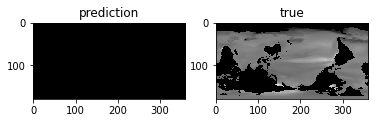

<Figure size 432x288 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2)


axis[0].imshow(np.squeeze(predicted_image[1]), cmap="gray", interpolation="nearest")
axis[0].set_title("prediction")
axis[1].imshow(np.squeeze(pco2_images[419:421][1]), cmap="gray", interpolation="nearest")
axis[1].set_title("true")

plt.show()
plt.savefig('model1_prediction.png')

## Testing Generalization Capability

Using Validation data of other dataset

In [28]:
val_dir_name="../data/data2"

chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2=read_xarray(val_dir_name)

In [ ]:
xco2_images=[]
min_xco2=np.min(xco2.XCO2.data)
max_xco2=np.max(xco2.XCO2.data)
new_min=0
new_max=255
print(min_xco2, max_xco2)
print()


for i in xco2.XCO2.data:
    num = (i-min_xco2)*(new_max-new_min)/(max_xco2-min_xco2)+new_min
    tmp = (np.repeat(num,180*360)).reshape(180,-1)
    xco2_images.append(tmp)

xco2_images=np.array(xco2_images)

print("xco2 shape: ")
print(xco2_images.shape, chl.Chl.data.shape)


chl_images=preprocess_image_reduced(chl.Chl.data)
mld_images=preprocess_image_reduced(mld.MLD.data)
sss_images=preprocess_image_reduced(sss.SSS.data)
sst_images=preprocess_image_reduced(sst.SST.data)
xco2_images=preprocess_image_reduced(xco2_images,xco2=True)
pco2_images=preprocess_image_reduced(pco2.pCO2.data)

X = np.stack((chl_images, mld_images, sss_images, sst_images,xco2_images), axis = 1)

X=X.reshape((421,180,360,5))
X.shape


In [ ]:
predicted_image=best_model.predict(X,verbose=1)

In [ ]:
figure, axis = plt.subplots(1, 2)

axis[0].imshow(np.squeeze(predicted_image[0]), cmap="gray", interpolation="nearest")
axis[0].set_title("val_prediction")
axis[1].imshow(np.squeeze(pco2_images[0]), cmap="gray", interpolation="nearest")
axis[1].set_title("val_true")

plt.show()

In [ ]:
# generalization works pretty well

In [ ]:
def inverse_scale_image(arr, df):
    old_min = np.min(df)
    old_max = np.max(df)
    output = arr*(old_max-old_min)/255 + old_min
    return output